# Model Interpretability

### Abstract
This notebook presents a comprehensive data analysis and predictive modeling approach aimed at understanding the factors influencing primary energy consumption per capita (kWh/person). The analysis begins with data preprocessing, including handling missing values, type conversion, feature selection, outlier handling, and normalization to prepare the dataset for further analysis. A significant part of the analysis involves feature selection using Random Forest Regressor and correlation analysis to identify the key variables that impact energy consumption. The selected features include GDP per capita, access to clean fuels for cooking, energy intensity level of primary energy, access to electricity, and various sources of electricity production. The notebook proceeds to model training and evaluation, where a Random Forest Regressor is employed to predict energy consumption per capita. Model performance is assessed using metrics such as RMSE, MAE, R-squared, and Explained Variance to ensure reliability and accuracy in predictions.

### Objective
The primary objective of this notebook is to analyze and model the determinants of primary energy consumption per capita using a dataset that encompasses various economic, social, and technological factors. By employing machine learning techniques, specifically a Random Forest Regressor, the study aims to identify and quantify the impact of selected features on energy consumption. This understanding is critical for policymakers, researchers, and stakeholders in the energy sector to make informed decisions regarding energy planning, efficiency improvements, and sustainable development strategies. The notebook emphasizes the importance of accurate feature selection and the effectiveness of Random Forest in handling such predictive tasks, offering insights into the complex dynamics of energy consumption patterns across different regions.


## Data Preprocessing
In this step, we perform initial data preprocessing tasks such as handling missing values, type conversion, and feature selection, Outlier Handling and Normalization to prepare the data for analysis and modeling.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import pyplot
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.linear_model import Ridge
!pip install opendatasets
import opendatasets as od
import pandas as pd

od.download('https://www.kaggle.com/datasets/anshtanwar/global-data-on-sustainable-energy') # insert ypu kaggle  username and key
data = pd.read_csv('/content/global-data-on-sustainable-energy/global-data-on-sustainable-energy (1).csv')



#file_path = '/content/drive/MyDrive/ds/dataset.gsheet'
#data = pd.read_csv(file_path)
#print(data.dtypes)
data.info()

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ramcuts
Your Kaggle Key: ··········


100%|██████████| 174k/174k [00:00<00:00, 32.0MB/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3649 entries, 0 to 3648
Data columns (total 21 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   Entity                                                            3649 non-null   object 
 1   Year                                                              3649 non-null   int64  
 2   Access to electricity (% of population)                           3639 non-null   float64
 3   Access to clean fuels for cooking                                 3480 non-null   float64
 4   Renewable-electricity-generating-capacity-per-capita              2718 non-null   float64
 5   Financial flows to developing countries (US $)                    1560 non-null   float64
 6   Renewable energy share in the total final energy consumption (%)  3455 non-null   float64
 7   Electricity from fossil fuels (T

In [ ]:
data.rename(columns={'Density\\n(P/Km2)': 'Density'}, inplace=True)
data['Density'] = pd.to_numeric(data['Density'], errors='coerce')
data = data.drop("Electricity from nuclear (TWh)", axis=1)
data.reset_index(drop=True, inplace=True)
label_encoder = LabelEncoder()
data['Entity'] = label_encoder.fit_transform(data['Entity'])


# Mean Imputation
numeric_columns = data.select_dtypes(include=['float64', 'int64', 'int32']).columns
data_numeric = data[numeric_columns]
mean_imputer = SimpleImputer(strategy='mean')
X_mean_imputed = mean_imputer.fit_transform(data_numeric)
df_mean_imputed = pd.DataFrame(X_mean_imputed, columns=numeric_columns)

#IQR
def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))
    return df

data_capped_label = df_mean_imputed.copy()

numerical_columns = df_mean_imputed.select_dtypes(include='number').columns
for column in numerical_columns:
    data_capped_label = cap_outliers_iqr(data_capped_label, column)

from sklearn.preprocessing import StandardScaler

columns_to_normalize = [
    'Access to electricity (% of population)',
    'Access to clean fuels for cooking',
    'Renewable-electricity-generating-capacity-per-capita',
    'Financial flows to developing countries (US $)',
    'Renewable energy share in the total final energy consumption (%)',
    'Electricity from fossil fuels (TWh)',
    'Electricity from renewables (TWh)',
    'Low-carbon electricity (% electricity)',
    'Primary energy consumption per capita (kWh/person)',
    'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
    'Value_co2_emissions_kt_by_country',
    'Renewables (% equivalent primary energy)',
    'gdp_growth',
    'gdp_per_capita',
    'Land Area(Km2)'
]

# Create the StandardScaler object
scaler = StandardScaler()
data_capped_label[columns_to_normalize] = scaler.fit_transform(data_capped_label[columns_to_normalize])


data_capped_label.isna().sum()

Entity                                                              0
Year                                                                0
Access to electricity (% of population)                             0
Access to clean fuels for cooking                                   0
Renewable-electricity-generating-capacity-per-capita                0
Financial flows to developing countries (US $)                      0
Renewable energy share in the total final energy consumption (%)    0
Electricity from fossil fuels (TWh)                                 0
Electricity from renewables (TWh)                                   0
Low-carbon electricity (% electricity)                              0
Primary energy consumption per capita (kWh/person)                  0
Energy intensity level of primary energy (MJ/$2017 PPP GDP)         0
Value_co2_emissions_kt_by_country                                   0
Renewables (% equivalent primary energy)                            0
gdp_growth          

In [ ]:
columns_imp = ['gdp_per_capita', 'Access to clean fuels for cooking',
               'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
               'Access to electricity (% of population)', 'Electricity from fossil fuels (TWh)',
               'Electricity from renewables (TWh)', 'Value_co2_emissions_kt_by_country',
               'Financial flows to developing countries (US $)',
               'Renewable energy share in the total final energy consumption (%)',
               'Renewables (% equivalent primary energy)',
               'Primary energy consumption per capita (kWh/person)']

# Create a new DataFrame with only the important columns
data_imp = data_capped_label[columns_imp].copy()

# Display the new DataFrame
print(data_imp)

      gdp_per_capita  Access to clean fuels for cooking  \
0           0.258405                          -1.496598   
1           0.258405                          -1.470367   
2          -0.921369                          -1.444137   
3          -0.920356                          -1.410037   
4          -0.918492                          -1.373314   
...              ...                                ...   
3644       -0.805667                          -0.877554   
3645       -0.826320                          -0.877554   
3646       -0.824568                          -0.874931   
3647       -0.818978                          -0.869685   
3648       -0.828181                          -0.861816   

      Energy intensity level of primary energy (MJ/$2017 PPP GDP)  \
0                                             -1.450034             
1                                             -1.406182             
2                                             -1.555278             
3              

## 1. Fit a linear model and interpret the regression coefficients

### Linear Regression
We are performing a linear regression analysis on a dataset to predict the primary energy consumption per capita (in kWh per person). Firstly, we import necessary libraries including scikit-learn's tools for model selection, linear regression, and metrics evaluation. Next, we prepare the dataset by separating the features (X) and the target variable (y). Then, we split the data into training and testing sets using the train_test_split function, with 70% of the data allocated for training and 30% for testing. Subsequently, we instantiate a Linear Regression model and train it on the training data. After training, we use the model to make predictions on the test set. Finally, we calculate evaluation metrics such as Mean Squared Error (MSE) and R-squared (R2) score to assess the performance of the model in predicting energy consumption per capita.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


X = data_imp.drop('Primary energy consumption per capita (kWh/person)', axis=1)
y = data_imp['Primary energy consumption per capita (kWh/person)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

model3 = LinearRegression()

model3.fit(X_train, y_train)

y_pred = model3.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [ ]:
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.19598008400970438
R-squared: 0.8002657061361984


The Mean Squared Error (MSE) of the model is approximately 0.196, indicating the average squared difference between the actual and predicted values of the target variable. A lower MSE suggests that the model's predictions are closer to the actual values, implying better performance.

The R-squared (R2) score of the model is approximately 0.800, signifying the proportion of variance in the target variable that is explained by the independent variables. A higher R2 score closer to 1 indicates that the model captures a larger amount of variation in the target variable, demonstrating a good fit to the data.

In [ ]:
import statsmodels.api as sm

Z = data_imp.drop('Primary energy consumption per capita (kWh/person)', axis=1)  # Features
target_variable = data_imp['Primary energy consumption per capita (kWh/person)']  # Your preferred target variable name

Z = sm.add_constant(X)
model = sm.OLS(target_variable, Z).fit()
print(model.summary())

                                            OLS Regression Results                                            
Dep. Variable:     Primary energy consumption per capita (kWh/person)   R-squared:                       0.810
Model:                                                            OLS   Adj. R-squared:                  0.810
Method:                                                 Least Squares   F-statistic:                     1553.
Date:                                                Sun, 17 Mar 2024   Prob (F-statistic):               0.00
Time:                                                        04:46:24   Log-Likelihood:                -2145.7
No. Observations:                                                3649   AIC:                             4313.
Df Residuals:                                                    3638   BIC:                             4382.
Df Model:                                                          10                                         
C

The Ordinary Least Squares (OLS) regression results indicate a strong overall fit of the model to the data, with an R-squared value of 0.810. This suggests that approximately 81% of the variance in the dependent variable, "Primary energy consumption per capita," is explained by the independent variables included in the model. The adjusted R-squared value, which takes into account the number of predictors in the model, also remains at 0.810, indicating that the inclusion of the independent variables has improved the model fit.

The coefficients of the independent variables provide insights into their individual effects on the dependent variable. For instance, the coefficient of "gdp_per_capita" is 0.7227, implying that a one-unit increase in GDP per capita is associated with an approximate increase of 0.7227 units in primary energy consumption per capita, holding other variables constant. Similarly, positive coefficients for other variables like "Access to clean fuels for cooking," "Energy intensity level of primary energy," and "Access to electricity (% of population)" suggest positive relationships with primary energy consumption per capita.

Additionally, the omnibus test for normality and the Jarque-Bera test for normality residuals suggest that the model residuals are not normally distributed (p < 0.05), indicating potential issues with the model assumptions. The Durbin-Watson statistic, which tests for autocorrelation in the residuals, is low at 0.207, suggesting a potential issue with residual independence. Overall, while the model demonstrates a good fit to the data based on the R-squared value, further diagnostics may be needed to assess the model's validity.


## 2. Fit a tree-based model and interpret the nodes

### Random Forest Regression

The following code trains a RandomForestRegressor model using scikit-learn's RandomForestRegressor class. It's a powerful model for regression tasks, capable of handling complex relationships between features and targets. We import necessary libraries and instantiate the model with a maximum depth of 10 and random state 5. After training on the training data, predictions are made on the test set, and performance metrics such as mean squared error (MSE) and R-squared (R2) are computed to assess model accuracy and goodness of fit.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
regr = RandomForestRegressor(max_depth=10, random_state=5)
model2 = regr.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
mse = mean_squared_error(y_test, y_pred2)
r2 = r2_score(y_test, y_pred2)

In [ ]:
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.03827935971118904
R-squared: 0.9609873578730878


The model achieved a remarkably low Mean Squared Error (MSE) of approximately 0.038, indicating that, on average, the squared difference between the predicted and actual values of the target variable is very small. Additionally, the R-squared value of approximately 0.961 suggests that around 96.1% of the variance in the target variable is explained by the independent variables included in the model. These results indicate a high level of accuracy and goodness of fit, demonstrating the effectiveness of the RandomForestRegressor model in capturing the underlying patterns in the data.

We are importing the `plot_tree` function from the `sklearn.tree` module and the `matplotlib.pyplot` module as `plt`. The `plot_tree` function allows us to visualize decision trees generated by machine learning models. We then convert the feature names into a list to pass to the `plot_tree` function for better visualization. Next, we select one tree from the RandomForestRegressor model (`model2`) using the `estimators_` attribute. Finally, we create a figure with a specified size using `plt.figure`, plot the selected tree using `plot_tree`, and display the plot using `plt.show()`.

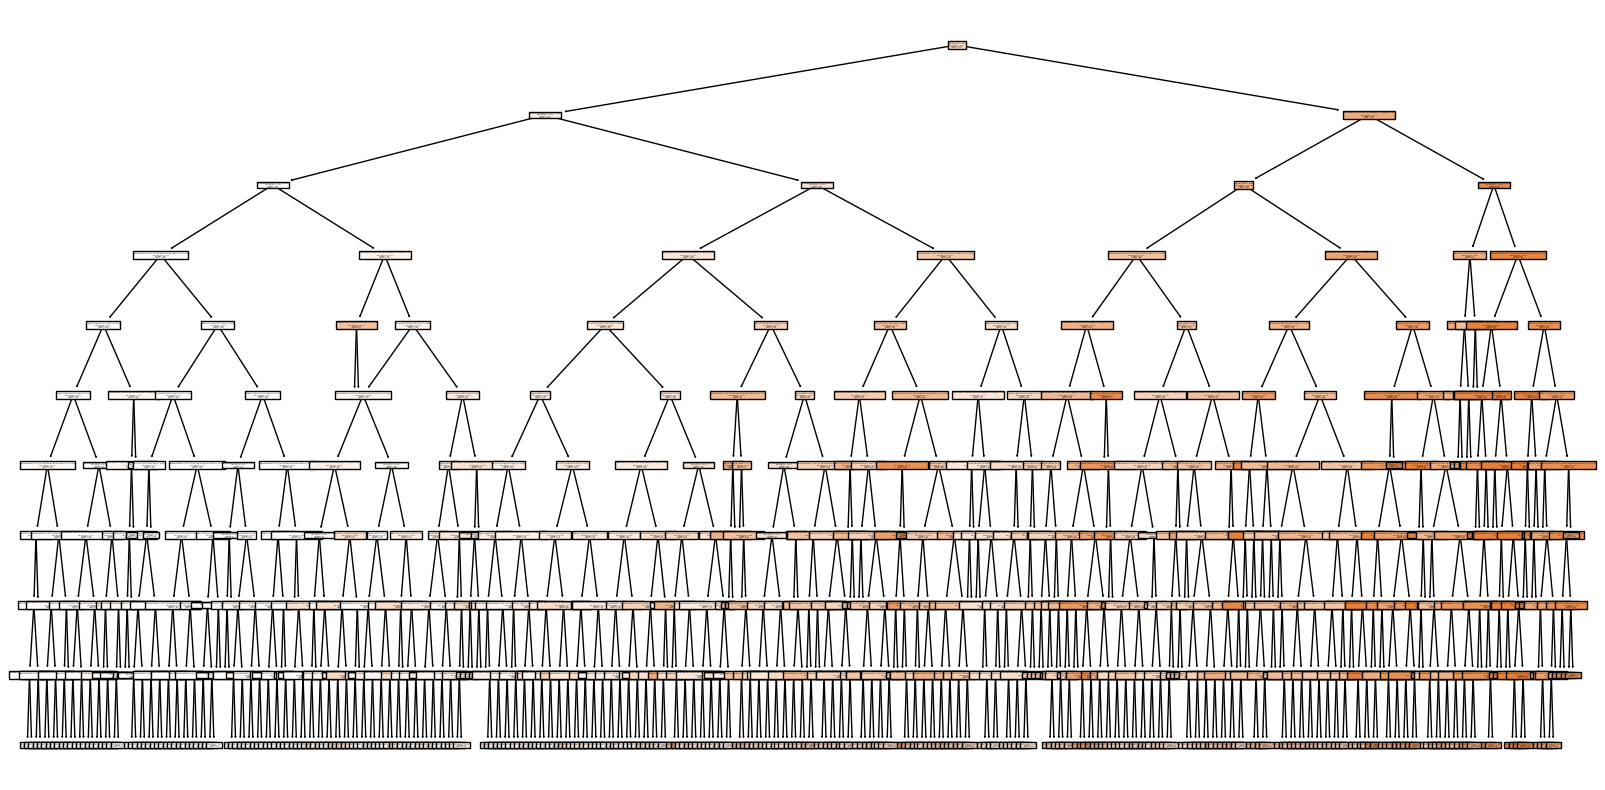

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Convert feature names to a list
feature_names_list = list(X.columns)
one_tree = model2.estimators_[11]

# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(one_tree, feature_names=feature_names_list, filled=True)
plt.show()

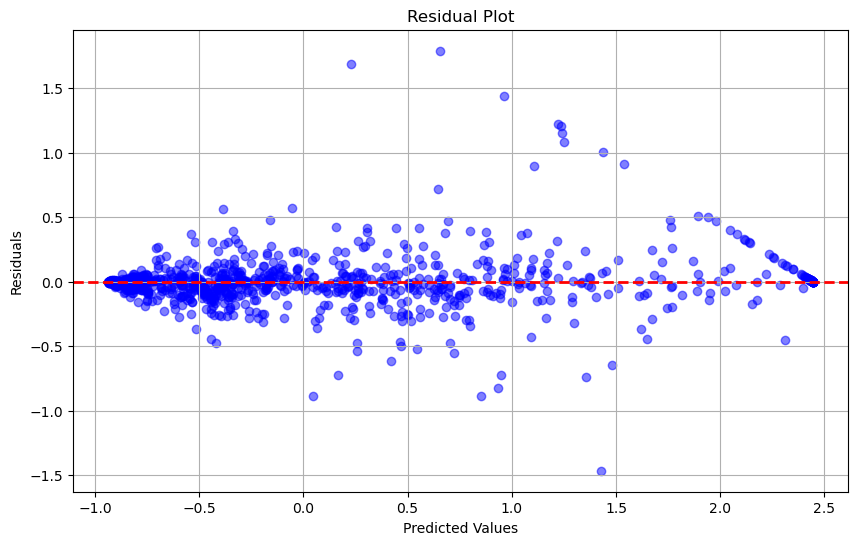

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate residuals
residuals = y_test - y_pred2

# Create the residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred2, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()


We are importing the `matplotlib.pyplot` module as `plt` and the `numpy` module as `np`. We calculate the residuals by subtracting the predicted values (`y_pred2`) from the actual values (`y_test`). Then, we create a scatter plot to visualize the relationship between the predicted values and the residuals. The residuals are plotted on the y-axis, and the predicted values are plotted on the x-axis. A red dashed line is drawn at y=0 to indicate the ideal residual value of 0. This plot helps us assess whether the residuals have a consistent spread across different predicted values, which is important for validating the assumptions of the linear regression model. Additionally, the grid lines are enabled for better readability.



The residual plot shows a random scattering of points around the zero axis, indicating that the residuals (the differences between the actual and predicted values) are randomly distributed across the range of predicted values.

## 3.  Use auto ml to find the best model

### AUTO ML

This code installs the H2O library, initializes H2O, and prepares data for Automated Machine Learning (AutoML) using H2O. The specified columns are selected from the dataset and converted to an H2OFrame. The data is then split into train and test sets, with an additional column indicating whether each row belongs to the train or test set. Next, an AutoML process is initiated with a maximum of 10 base models, using Mean Absolute Error (MAE) as the sort metric and a specified project name. The AutoML process trains models to predict the 'Primary energy consumption per capita (kWh/person)' based on the selected features.

In [ ]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html


In [ ]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM Corretto-17.0.8.8.1 (build 17.0.8.1+8-LTS, mixed mode, sharing)
  Starting server from C:\Users\himav\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\himav\AppData\Local\Temp\tmpc3131a_c
  JVM stdout: C:\Users\himav\AppData\Local\Temp\tmpc3131a_c\h2o_himav_started_from_python.out
  JVM stderr: C:\Users\himav\AppData\Local\Temp\tmpc3131a_c\h2o_himav_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,2 months and 25 days
H2O_cluster_name:,H2O_from_python_himav_ovguid
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4.941 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [ ]:
columns_imp = ['gdp_per_capita', 'Access to clean fuels for cooking',
                   'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
                   'Access to electricity (% of population)', 'Electricity from fossil fuels (TWh)',
                   'Electricity from renewables (TWh)', 'Value_co2_emissions_kt_by_country',
                   'Financial flows to developing countries (US $)',
                   'Renewable energy share in the total final energy consumption (%)',
                   'Renewables (% equivalent primary energy)',
                   'Primary energy consumption per capita (kWh/person)']

# Keep only the specified columns
filtered_df = data_capped_label[columns_imp]

data = h2o.H2OFrame(filtered_df)

train, test = data.split_frame(seed = 1234, destination_frames = ["train.hex", "test.hex"])
train["is_train"] = 1
test["is_train"] = 0
drift_data = train.rbind(test)
drift_data["is_train"] = drift_data["is_train"].asfactor()
drift_data["is_train"].table()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


is_train,Count
0,903
1,2746


In [ ]:
x = list(set(train.col_names) - set(["Primary energy consumption per capita (kWh/person)"]))
from h2o.automl import H2OAutoML
# Run AutoML for 10 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=10, seed=1234, sort_metric="MAE", project_name = "random_split")
aml.train(x=x, y="Primary energy consumption per capita (kWh/person)", training_frame=train)

AutoML progress: |
04:47:23.89: AutoML: XGBoost is not available; skipping it.
04:47:23.140: _train param, Dropping bad and constant columns: [is_train]


04:47:24.106: _train param, Dropping bad and constant columns: [is_train]

███
04:47:28.666: _train param, Dropping bad and constant columns: [is_train]

██
04:47:31.483: _train param, Dropping bad and constant columns: [is_train]

██
04:47:34.754: _train param, Dropping bad and constant columns: [is_train]

█
04:47:36.77: _train param, Dropping bad and constant columns: [is_train]

█
04:47:37.530: _train param, Dropping bad and constant columns: [is_train]

███
04:47:40.404: _train param, Dropping bad and constant columns: [is_train]
04:47:41.748: _train param, Dropping bad and constant columns: [is_train]

███
04:47:44.810: _train param, Dropping unused columns: [is_train]

████████████████████████████████████████████████| (done) 100%

04:47:45.571: _train param, Dropping unused columns: [is_train]



key,value
Stacking strategy,cross_validation
Number of base models (used / total),6/10
# GBM base models (used / total),4/6
# DRF base models (used / total),2/2
# DeepLearning base models (used / total),0/1
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [ ]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head()

model_id,mae,rmse,mse,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_1_20240317_44723,0.069086,0.139481,0.0194551,0.15521,0.0194551
StackedEnsemble_BestOfFamily_1_AutoML_1_20240317_44723,0.0700533,0.141298,0.0199651,0.161088,0.0199651
GBM_grid_1_AutoML_1_20240317_44723_model_1,0.0707193,0.143008,0.0204513,0.151157,0.0204513
GBM_4_AutoML_1_20240317_44723,0.0720216,0.144109,0.0207674,0.162763,0.0207674
DRF_1_AutoML_1_20240317_44723,0.0753892,0.149821,0.0224463,0.175886,0.0224463
GBM_3_AutoML_1_20240317_44723,0.0758357,0.144972,0.0210168,0.170523,0.0210168
GBM_2_AutoML_1_20240317_44723,0.076284,0.146663,0.0215101,0.175726,0.0215101
XRT_1_AutoML_1_20240317_44723,0.0769952,0.151409,0.0229246,0.178417,0.0229246
GBM_5_AutoML_1_20240317_44723,0.0815073,0.15602,0.0243422,0.196344,0.0243422
GBM_1_AutoML_1_20240317_44723,0.118937,0.194902,0.0379867,nan,0.0379867


These metrics provide insights into the performance of different models generated by the AutoML process. Lower values for metrics such as Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), Mean Squared Error (MSE), and Root Mean Squared Logarithmic Error (RMSLE) indicate better model performance. The Stacked Ensemble models seem to perform the best overall, with the "StackedEnsemble_AllModels_1" model having the lowest MAE of 0.069086. However, it's essential to consider other factors such as model complexity, interpretability, and computational efficiency when selecting the final model.

In [ ]:
best_model = aml.leader
best_model.model_performance(test)

ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 0.033289932659040025
RMSE: 0.18245528947947776
MAE: 0.07795472107061333
RMSLE: 0.21084796430960492
Mean Residual Deviance: 0.033289932659040025
R^2: 0.9664055383404226
Null degrees of freedom: 902
Residual degrees of freedom: 896
Null deviance: 895.1546662191137
Residual deviance: 30.06080919111314
AIC: -493.8547350133166

This set of metrics evaluates the performance of a stacked ensemble model on test data. The Mean Squared Error (MSE) of 0.0332 and Root Mean Squared Error (RMSE) of 0.1825 indicate the average squared and absolute errors, respectively, with lower values suggesting better fit. The Mean Absolute Error (MAE) of 0.0779 represents the average absolute difference between predicted and actual values. The Root Mean Squared Logarithmic Error (RMSLE) of 0.2108 measures the ratio between the actual and predicted values, with lower values indicating better performance. The R-squared value of 0.9664 suggests that approximately 96.6% of the variance in the dependent variable is explained by the model. These metrics collectively indicate strong predictive performance, with low errors and high explanatory power.

Let's write code which iterates over the base models within the best model obtained from the AutoML process. For each base model, it retrieves the actual model object from H2O, prints the model ID, and generates a variable importance plot. This plot visualizes the importance of each feature in predicting the target variable according to the corresponding model. By examining these plots for each base model, we can gain insights into which features have the most significant impact on the model's predictions and potentially identify key factors driving the target variable's behavior.


Variable importance for GBM_grid_1_AutoML_1_20240317_44723_model_1:


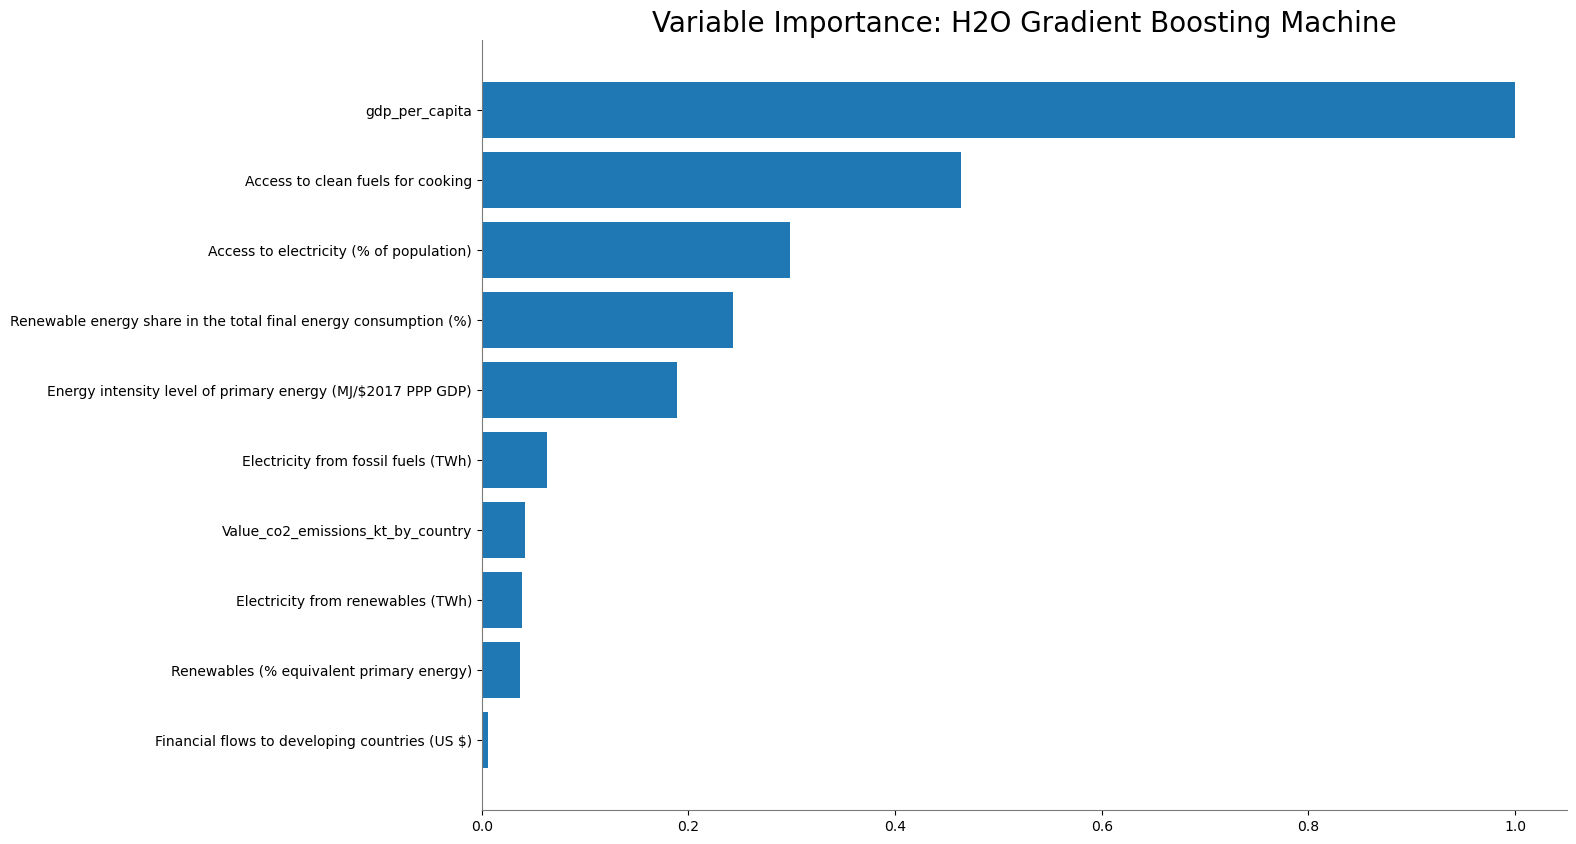

Variable importance for GBM_4_AutoML_1_20240317_44723:


<Figure size 640x480 with 0 Axes>

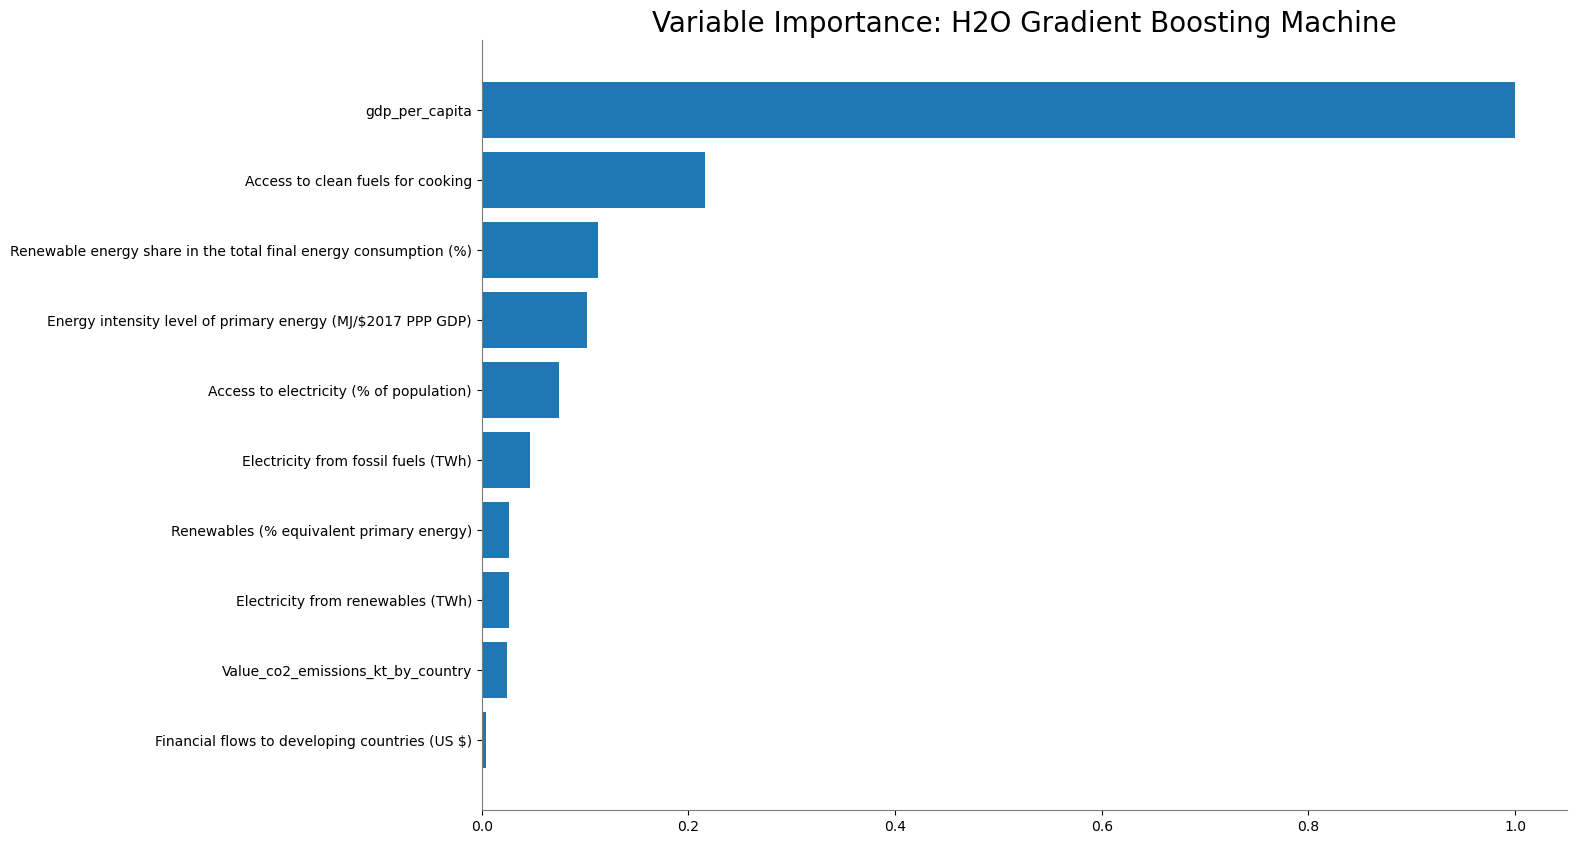

Variable importance for DRF_1_AutoML_1_20240317_44723:


<Figure size 640x480 with 0 Axes>

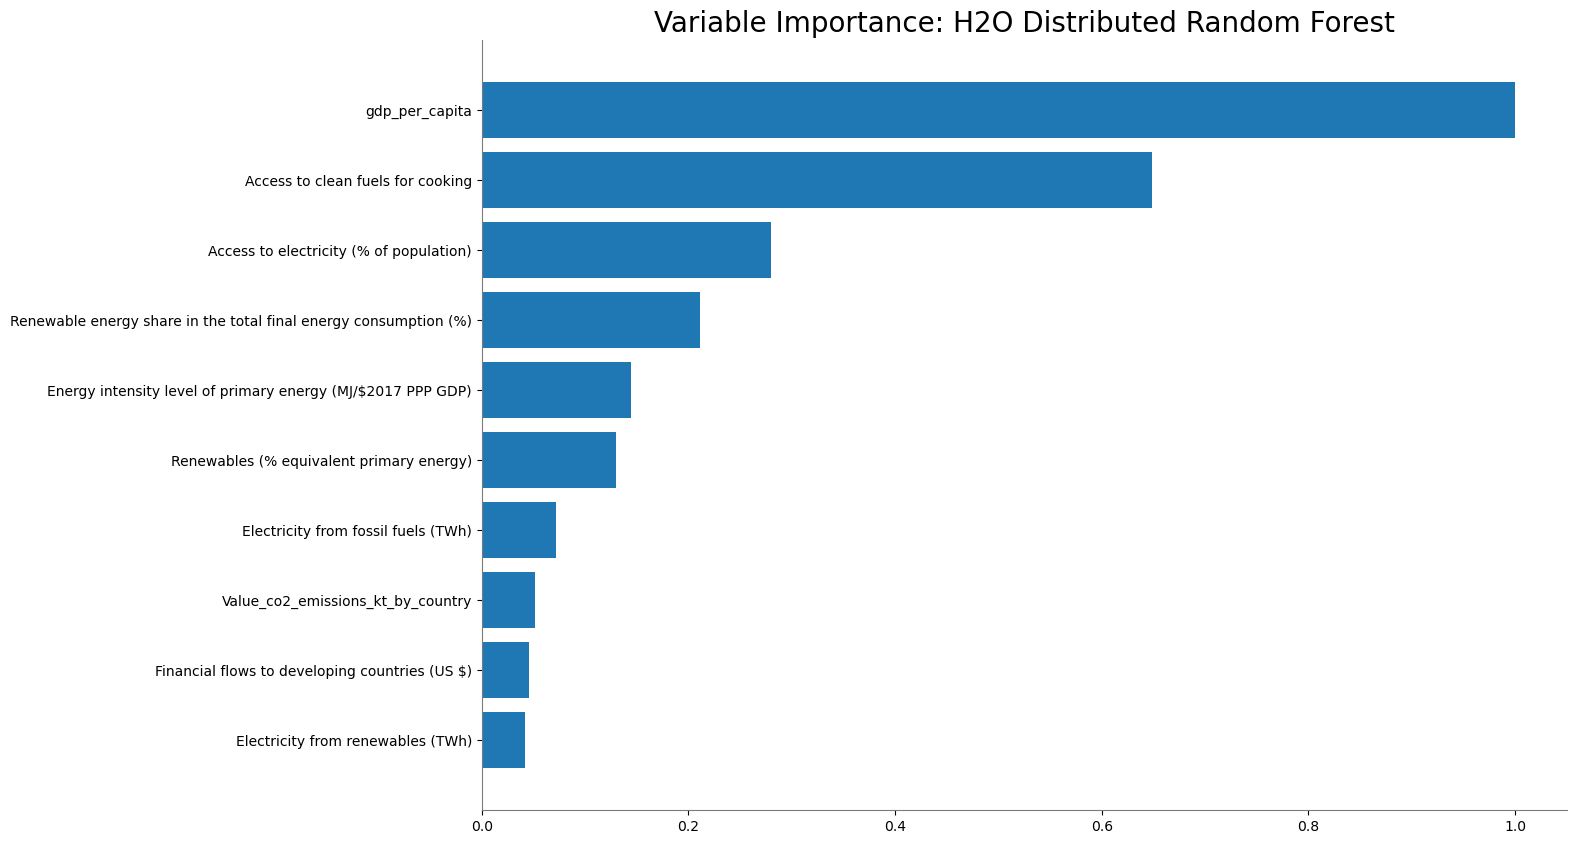

Variable importance for GBM_3_AutoML_1_20240317_44723:


<Figure size 640x480 with 0 Axes>

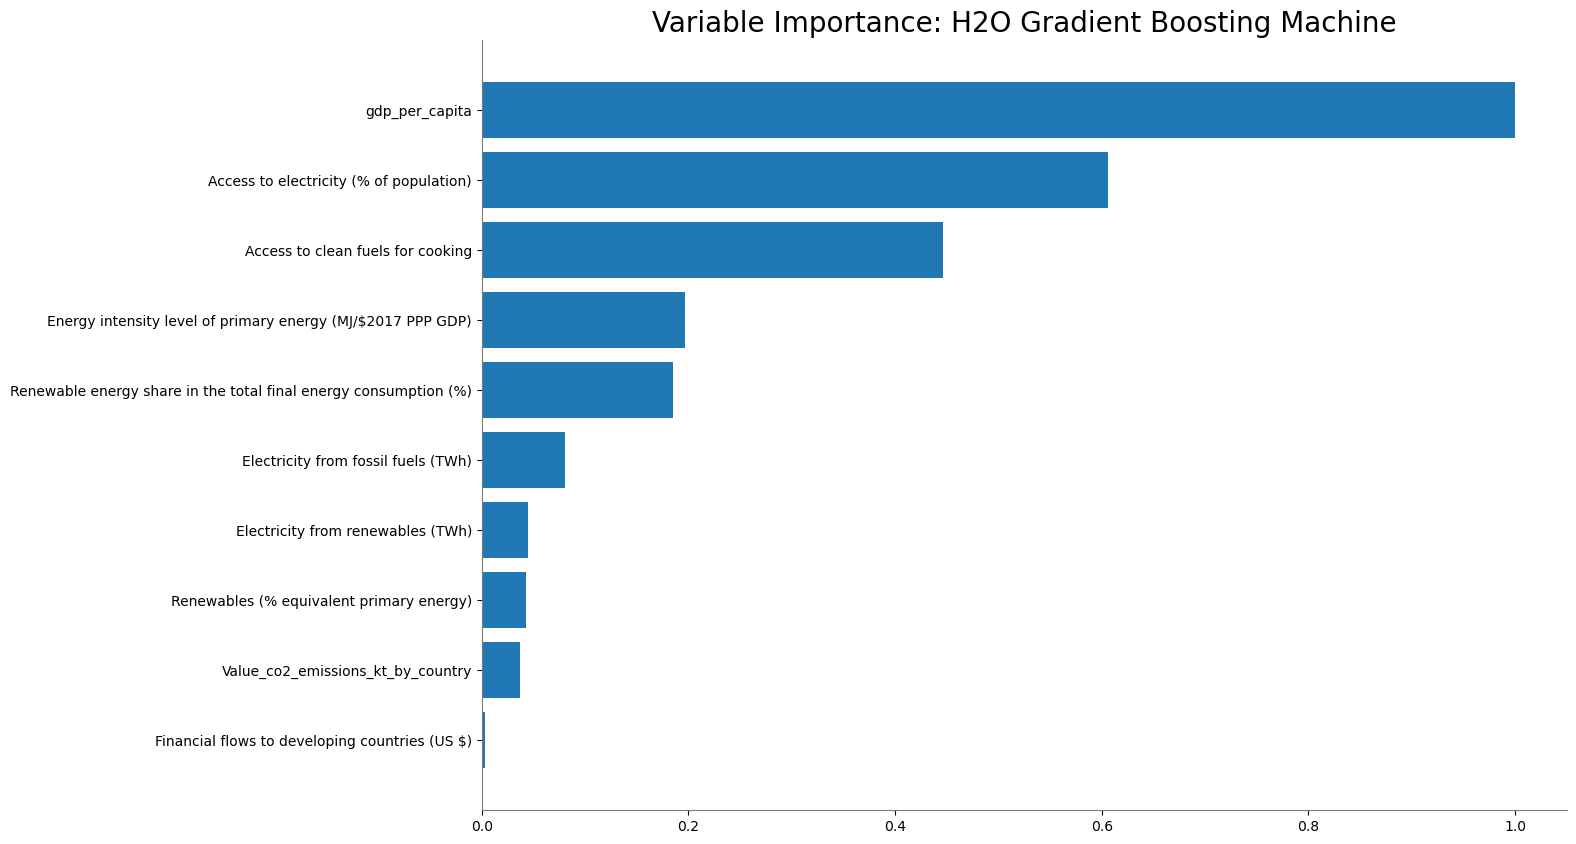

Variable importance for GBM_2_AutoML_1_20240317_44723:


<Figure size 640x480 with 0 Axes>

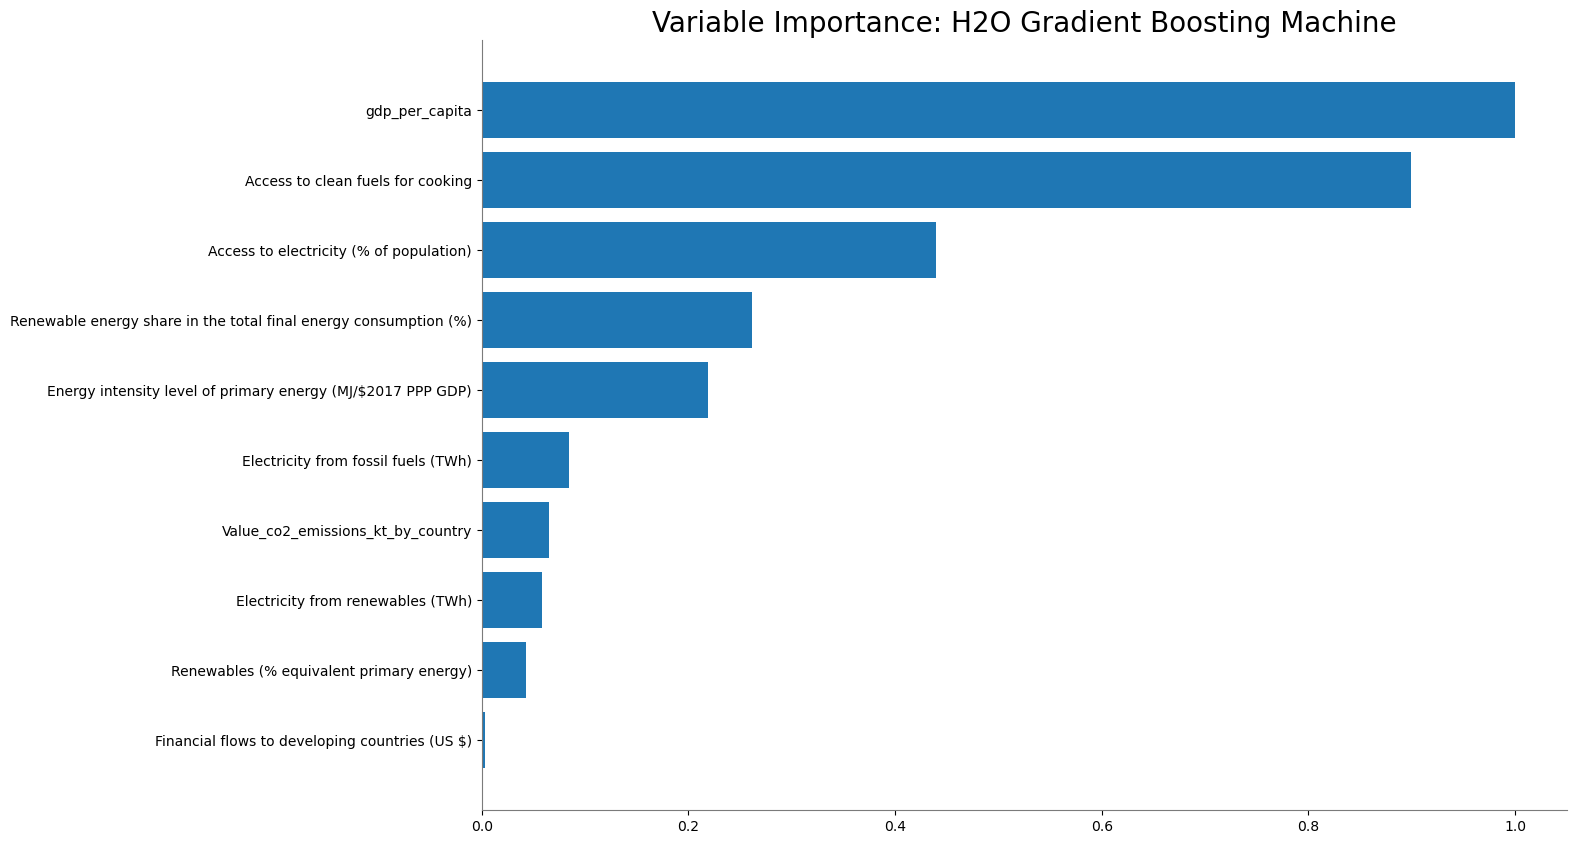

Variable importance for XRT_1_AutoML_1_20240317_44723:


<Figure size 640x480 with 0 Axes>

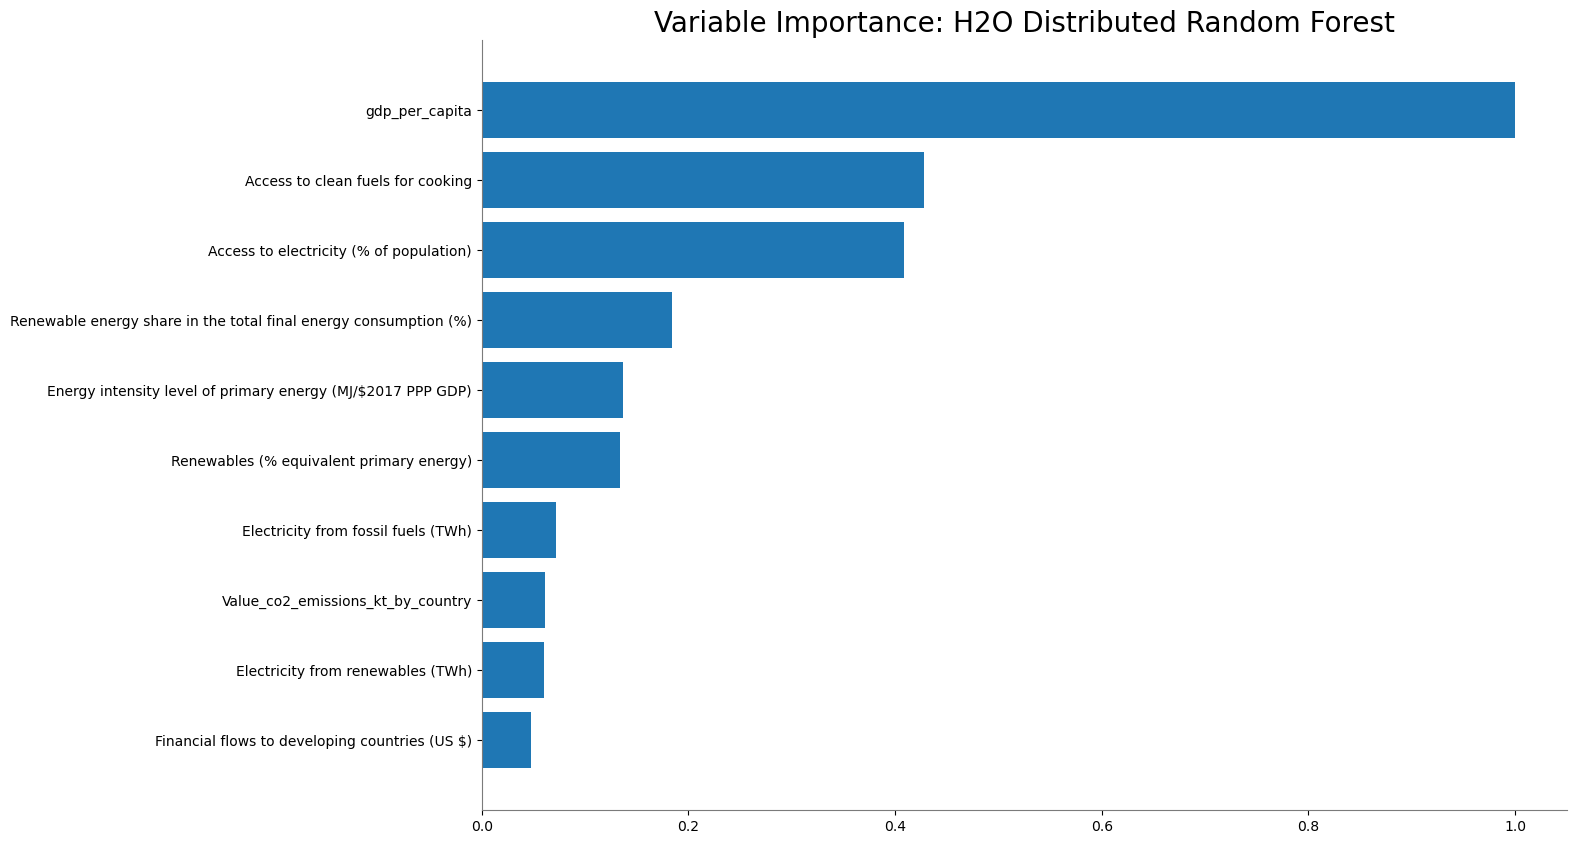

Variable importance for GBM_5_AutoML_1_20240317_44723:


<Figure size 640x480 with 0 Axes>

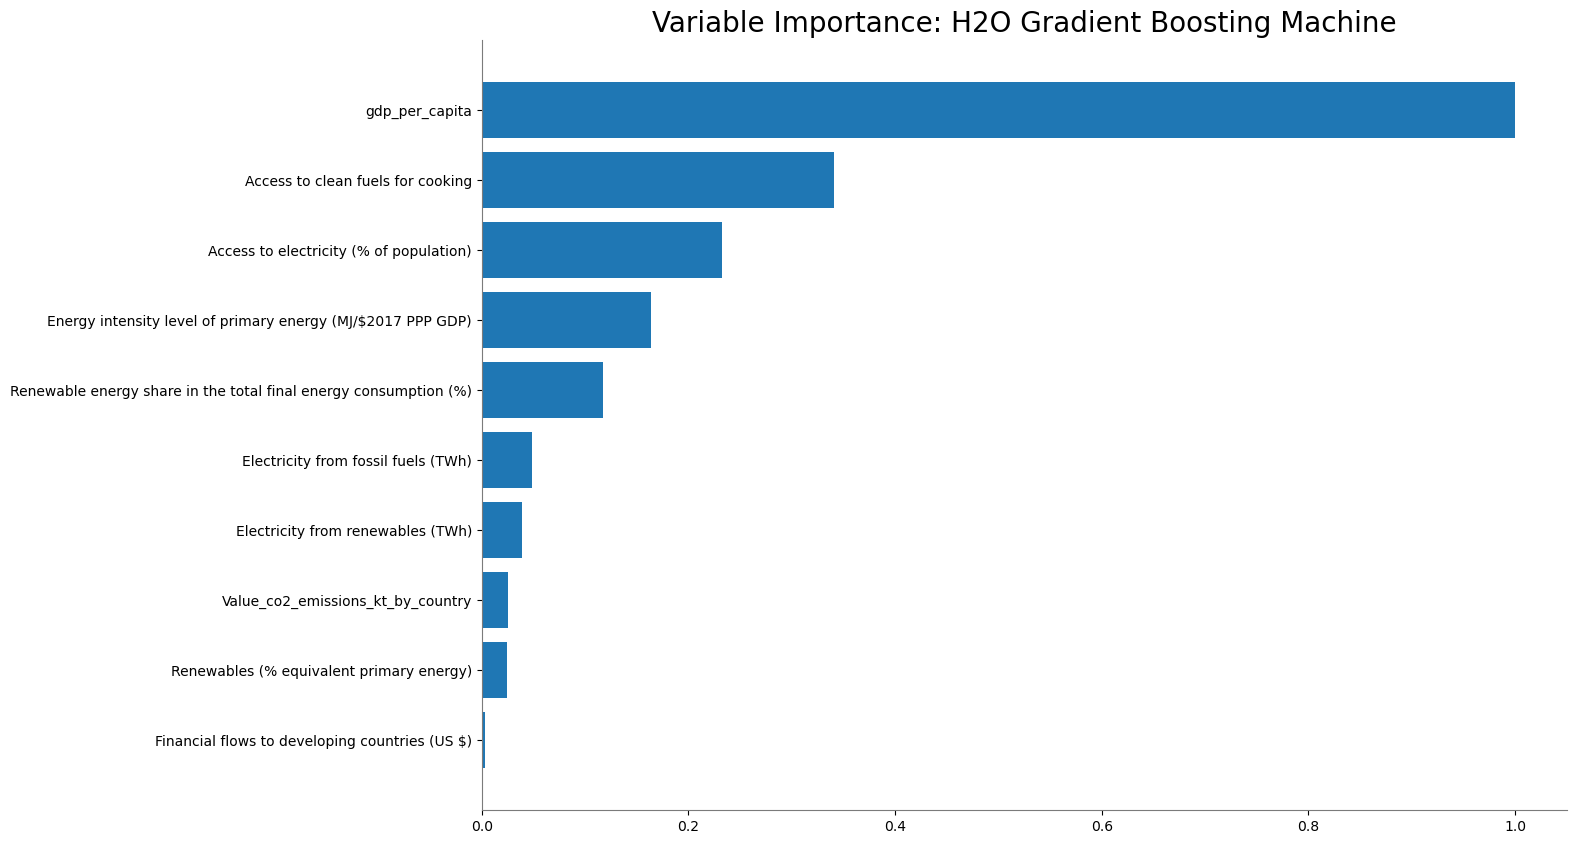

Variable importance for GBM_1_AutoML_1_20240317_44723:


<Figure size 640x480 with 0 Axes>

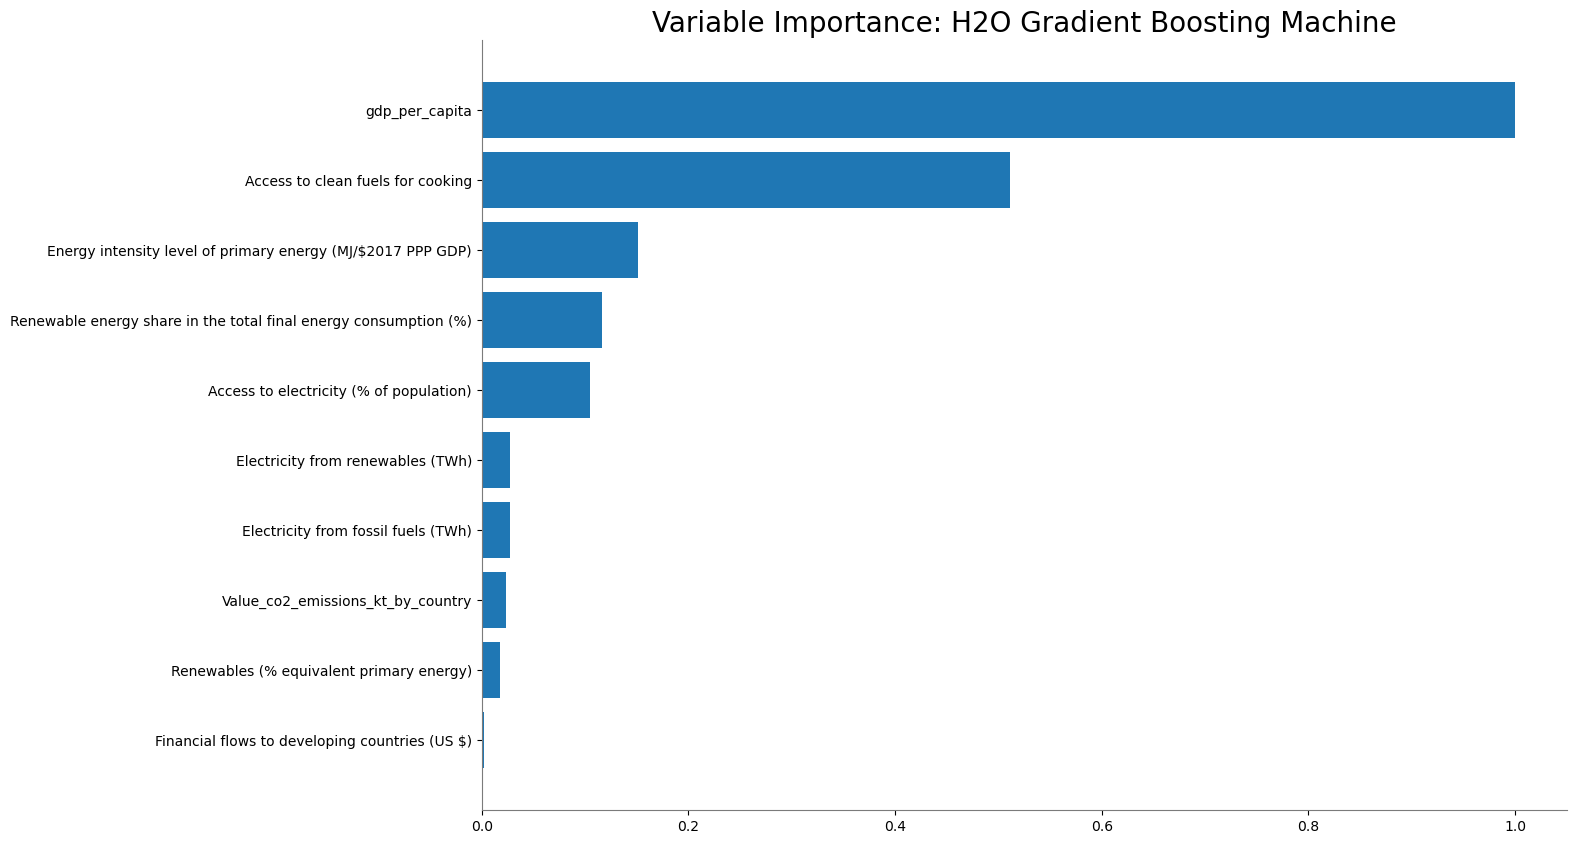

Variable importance for DeepLearning_1_AutoML_1_20240317_44723:


<Figure size 640x480 with 0 Axes>

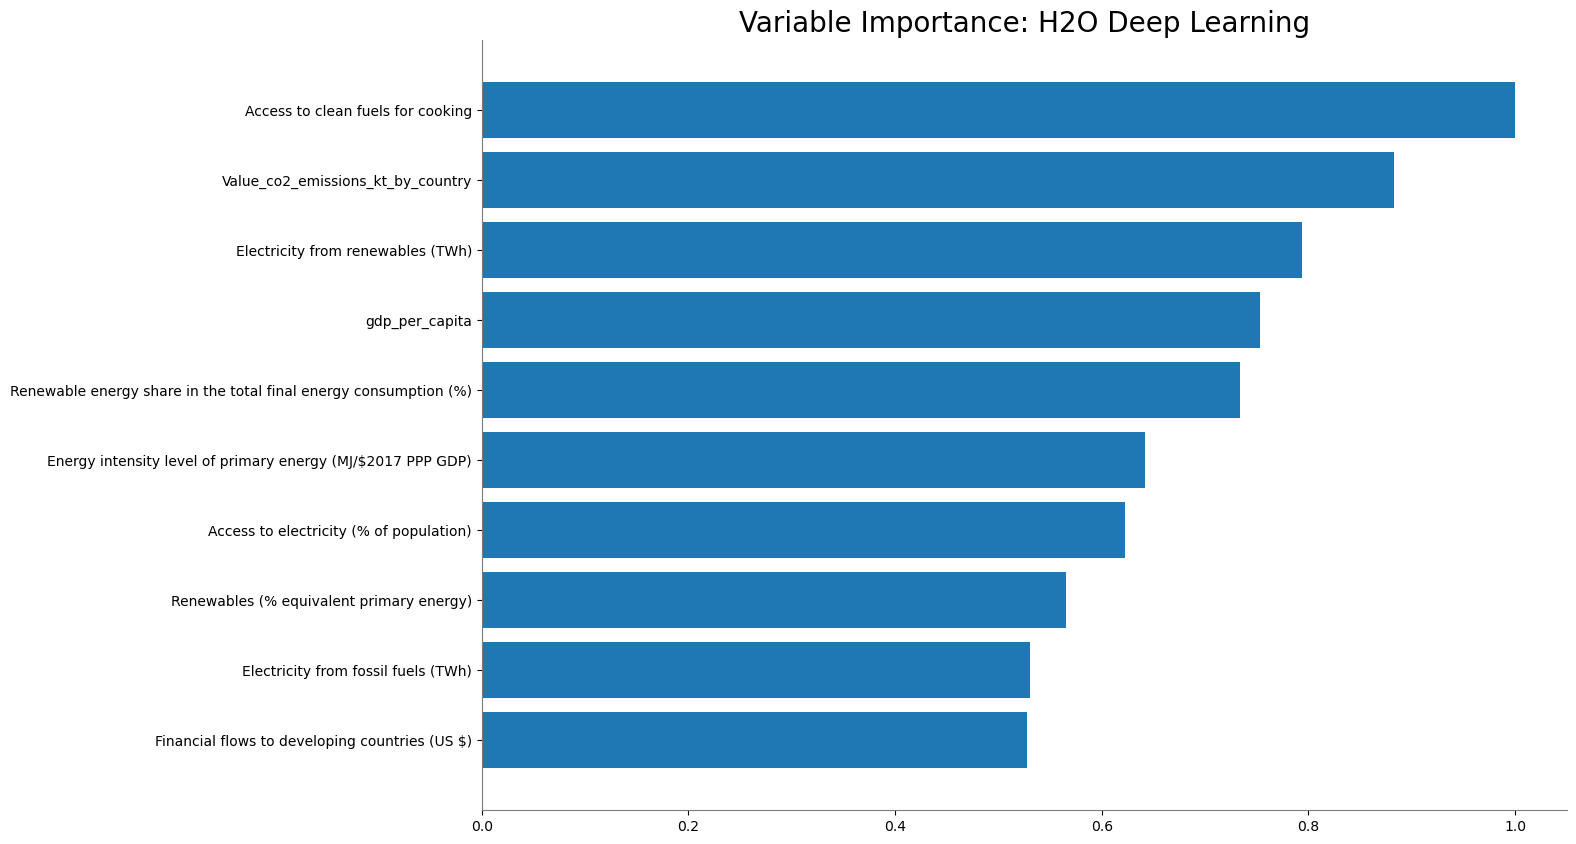

Variable importance for GLM_1_AutoML_1_20240317_44723:


<Figure size 640x480 with 0 Axes>

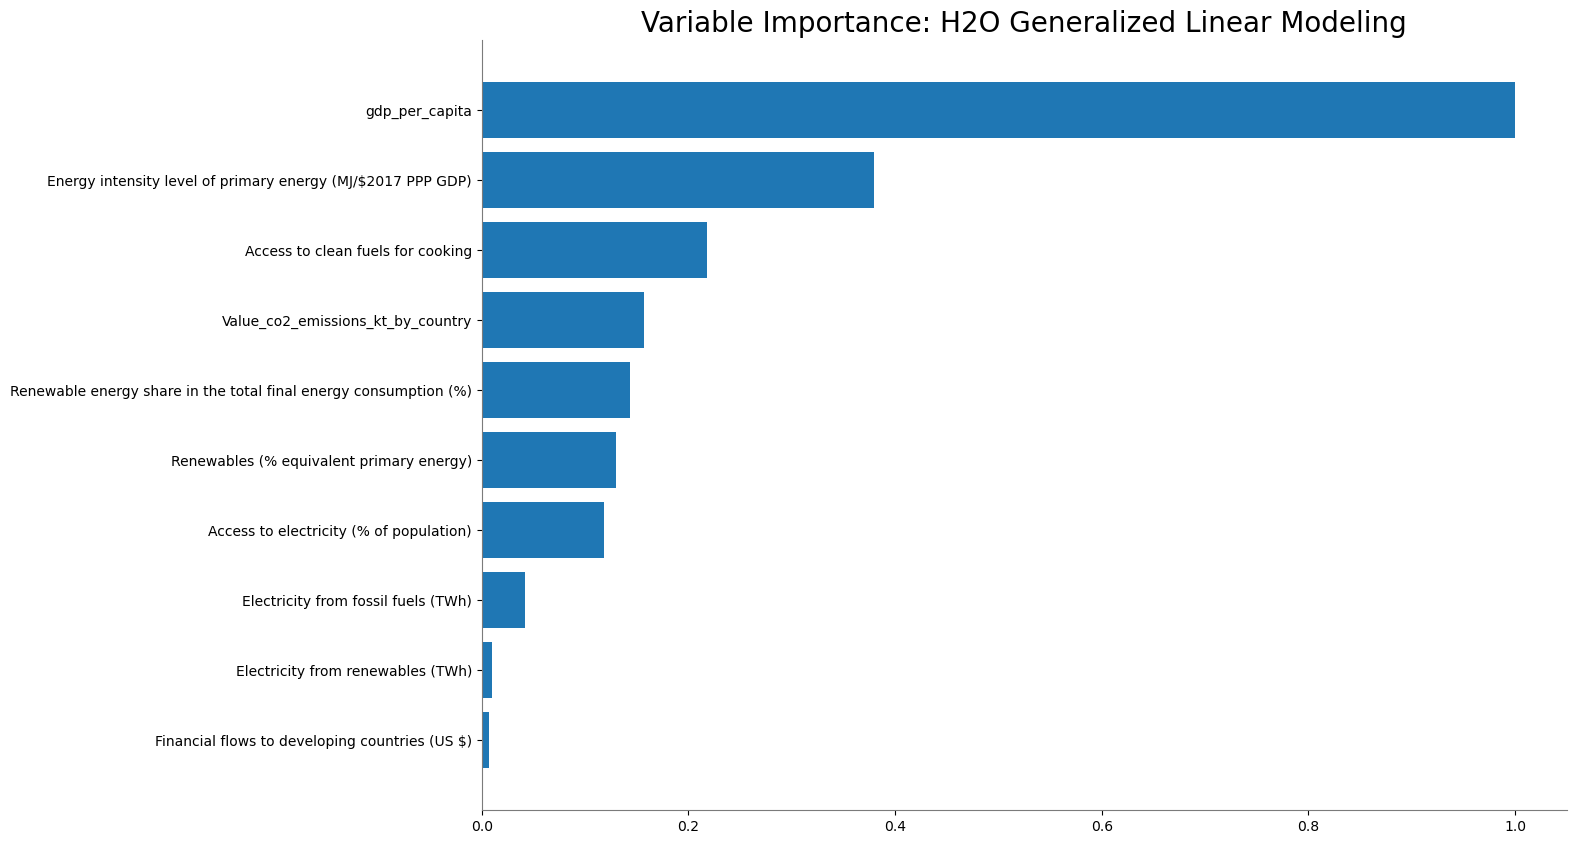

<Figure size 640x480 with 0 Axes>

In [ ]:
base_models = best_model.base_models

for model_id in base_models:
    # Retrieve the actual model object
    model = h2o.get_model(model_id)

    print(f"Variable importance for {model.model_id}:")
    model.varimp_plot()

Let's write code which generates an explanation for the AutoML model's predictions using the test data frame. It includes variable importance explanations, which highlight the importance of each feature in making predictions. The `figsize` parameter specifies the size of the resulting plot, and it's set to (8,6) to control the dimensions. By generating this explanation, we can understand which features are the most influential in the model's decision-making process, providing insights into the underlying patterns and relationships learned by the model.


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

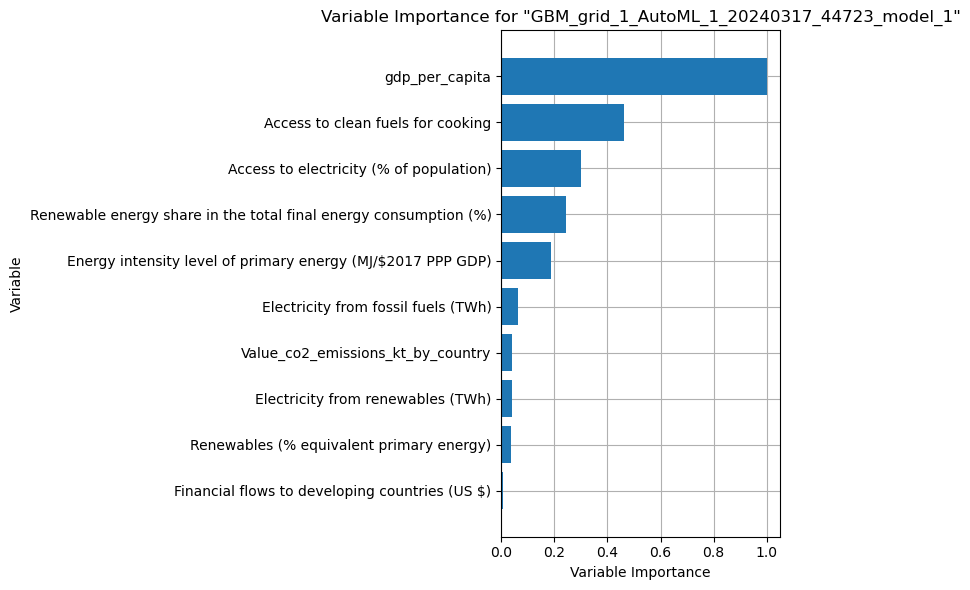

In [ ]:
explain_model = aml.explain(frame = test, figsize = (8,6),include_explanations=['varimp'])

### Relative Importance of Factors for Model "GBM_grid_1_AutoML_1_20240317_44723_model_1"


- **High Importance Factors:**
  - "GDP per Capita": Gross Domestic Product per capita emerges as one of the most influential factors for this model.
  - "Access to Electricity (% of Population)": The percentage of the population with access to electricity also holds significant importance.
  - "Renewable Energy Share in Total Final Energy Consumption (%)": This factor ranks prominently in the model's feature importance.

- **Low Importance Factors:**
  - "Electricity from Fossil Fuels (TWh)": This factor appears to have relatively less influence on the model's predictions.
  - "Value CO2 Emissions (kT by Country)": Similarly, the value of CO2 emissions by country seems to be less impactful in this model's predictions.

model_id,mae,rmse,mse,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_1_AutoML_1_20240317_44723,0.069086,0.139481,0.0194551,0.15521,0.0194551,882,0.037712,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_1_20240317_44723,0.0700533,0.141298,0.0199651,0.161088,0.0199651,754,0.02331,StackedEnsemble
GBM_grid_1_AutoML_1_20240317_44723_model_1,0.0707193,0.143008,0.0204513,0.151157,0.0204513,401,0.022839,GBM
GBM_4_AutoML_1_20240317_44723,0.0720216,0.144109,0.0207674,0.162763,0.0207674,441,0.022274,GBM
DRF_1_AutoML_1_20240317_44723,0.0753892,0.149821,0.0224463,0.175886,0.0224463,671,0.015532,DRF
XRT_1_AutoML_1_20240317_44723,0.0769952,0.151409,0.0229246,0.178417,0.0229246,853,0.014158,DRF
DeepLearning_1_AutoML_1_20240317_44723,0.238058,0.356884,0.127366,nan,0.127366,307,0.003888,DeepLearning
GLM_1_AutoML_1_20240317_44723,0.315771,0.43299,0.18748,nan,0.18748,65,0.000532,GLM


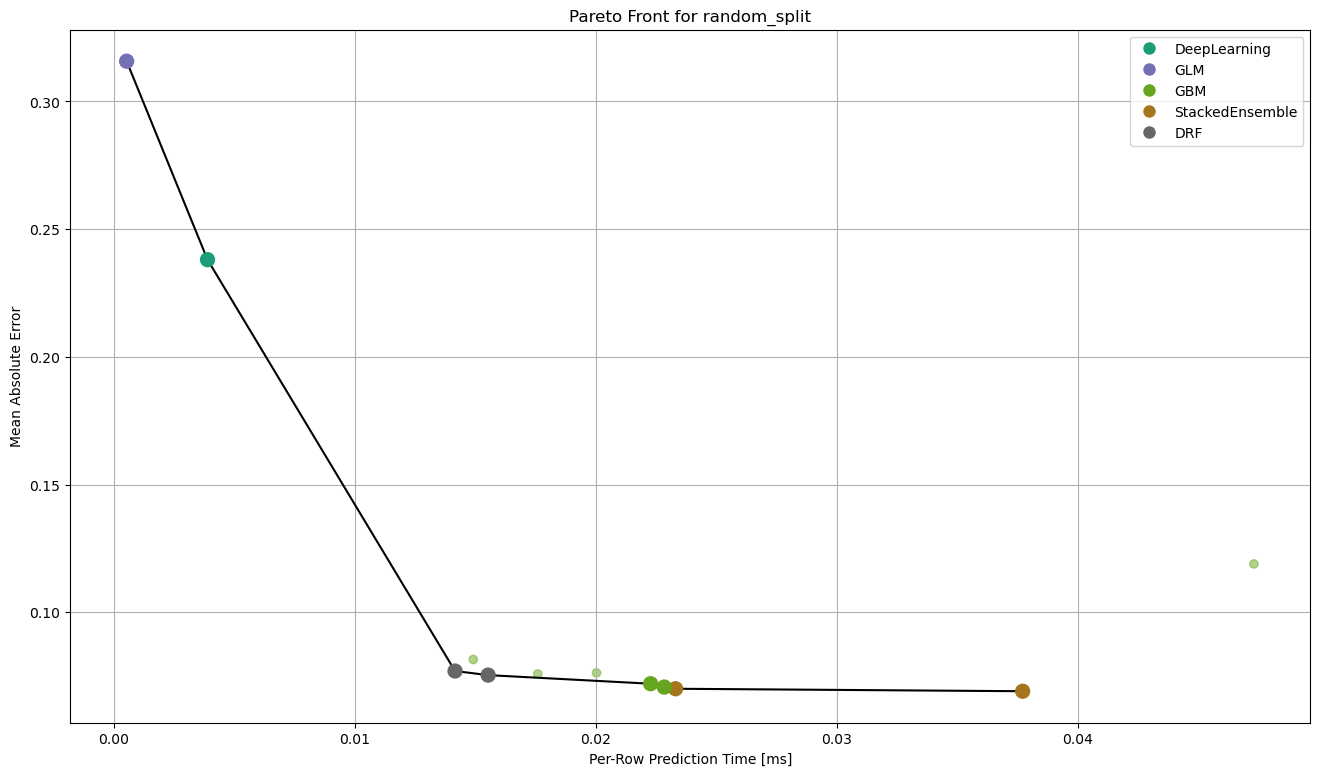

In [ ]:
pf = aml.pareto_front()
pf.figure()
pf

- StackedEnsemble models perform well across all metrics with low errors (MAE, RMSE, MSE, RMSLE) and low mean residual deviance. They also have relatively short training times.
- GBM models also show good performance, with low error metrics and reasonable training times.
- DRF models have slightly higher errors compared to GBM and StackedEnsemble but still perform reasonably well.
- DeepLearning and GLM models exhibit higher errors compared to other models and have longer training times, indicating potentially less optimal performance.
- Among all models, StackedEnsemble models seem to provide the best balance of performance and efficiency.

#### Performance Range:
The spread of points on the Pareto front illustrates a wide range of achievable trade-offs between speed (prediction time) and accuracy (MAE). This indicates a diverse selection of models catering to different needs.

#### Accuracy vs. Speed:
Consistent with expectations, the plot demonstrates the classic accuracy-speed trade-off. Models with lower prediction times tend to exhibit higher Mean Absolute Error (MAE), while those with higher accuracy typically incur longer prediction times.


## 4. Run SHAP analysis on the models from steps 1, 2, and 3,   interpret the SHAP values and compare them with the other model interpretability methods.

### SHAP Analysis

First, we'll install the SHAP (SHapley Additive exPlanations) library using pip. This library is widely used for explaining machine learning models.

Next, we import necessary libraries including random, SHAP, matplotlib, and make_regression from sklearn.datasets.

To ensure reproducibility, we set the random seed using np.random.seed(123).

We then sample 50 instances from the training and test datasets using SHAP's utility function, shap.utils.sample().

After that, we initialize a SHAP explainer object, rfe_explainer, using the RandomForestRegressor model (model2) to explain the predictions on the sampled test data.

Finally, we compute SHAP values for the test data using the explainer by calling rfe_explainer(x_test_50).


In [ ]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


#### Random Forest Regression SHAP

In [ ]:
import random
import shap
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression


np.random.seed(123)

x_train_50 = shap.utils.sample(X_train, 50, random_state=123)
x_test_50 = shap.utils.sample(X_test, 50, random_state=123)

In [ ]:
rfe_explainer = shap.Explainer(model2.predict, x_train_50, seed = 1)
rfe_shap_values = rfe_explainer(x_test_50)

ExactExplainer explainer: 51it [00:14,  1.41it/s]                        


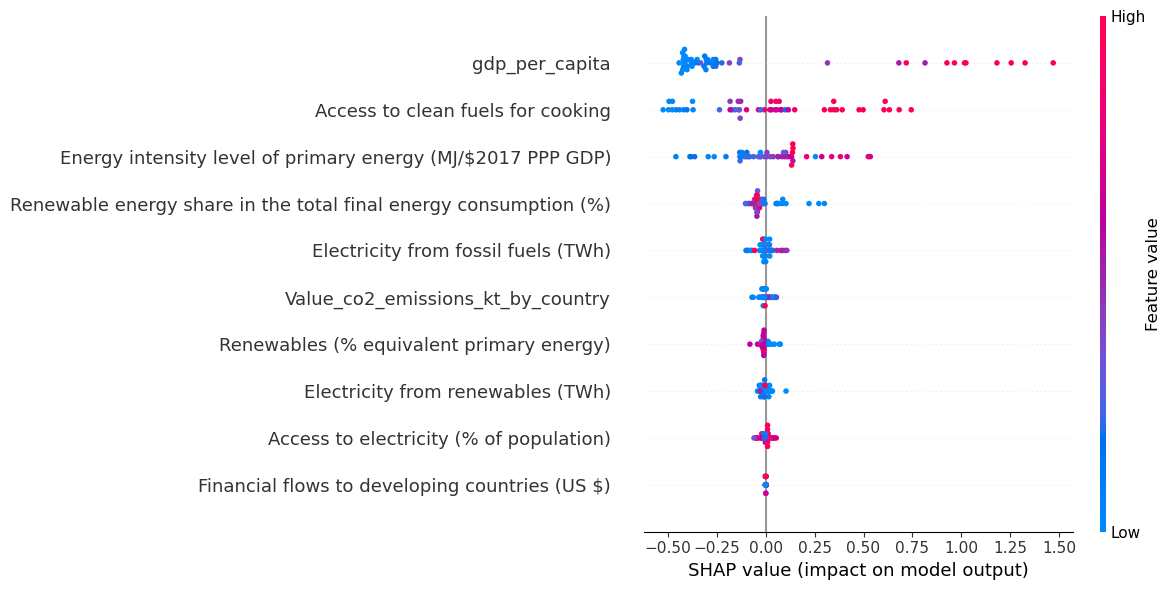

In [ ]:
shap.summary_plot(rfe_shap_values, x_test_50, plot_size=(12, 6))

The plot depicts how different features influence the output of the model for a specific data instance. Feature names are listed on the left side of the plot, and the color bar indicates the impact on the model's prediction. Red signifies a positive impact, while blue denotes a negative impact. Higher absolute values indicate a stronger influence.

### Key Observations
- **Predicted Outcome:**
  - The model is predicting a high value (potentially indicating a favorable outcome) for this particular data instance.

- **Positive Impact Feature:**
  - "GDP per Capita": Gross Domestic Product per capita emerges as the feature with the most substantial positive impact on the prediction. A higher GDP per capita leads to a stronger prediction of a high value by the model.

- **Negative Impact Feature:**
  - "Renewables (% Equivalent Primary Energy)": This feature exhibits a negative impact on the prediction. A higher percentage of renewable energy correlates with a weaker prediction of a high value by the model.

Understanding how individual features influence the model's predictions provides valuable insights into its decision-making process. In this context, the model seems to place significant importance on economic indicators such as GDP per capita, while renewable energy share has a contrasting effect on the predicted outcome.


#### Linear Regression SHAP

First, we convert the DataFrame x_test_50 to an H2OFrame called x_test_50_h2o using the H2OFrame function from the h2o library.

Next, we define a Python class called H2OProbWrapper, which serves as a wrapper for the H2O model to be used with SHAP. The class includes a method called predict_binary_prob, which takes input data X and returns the probabilities of the positive class (True) predicted by the H2O model.

Then, assuming 'selected_features' is a list of top 10 feature names, we initialize the H2OProbWrapper instance h2o_wrapper with the best_model and the selected features.

After that, we proceed with the SHAP explainer using the KernelExplainer from the shap library. We provide the predict_binary_prob method from the h2o_wrapper as the model function and use a subset of the training data (X_train_selected[:45]) to explain the predictions on a subset of the test data (X_test_selected[:45]).

Finally, we visualize the summary plot of SHAP values for the selected features using shap.summary_plot(), specifying the plot type as "bar" and setting the plot size as (12, 5). Additionally, we generate another summary plot without specifying the plot type, which defaults to "dot".


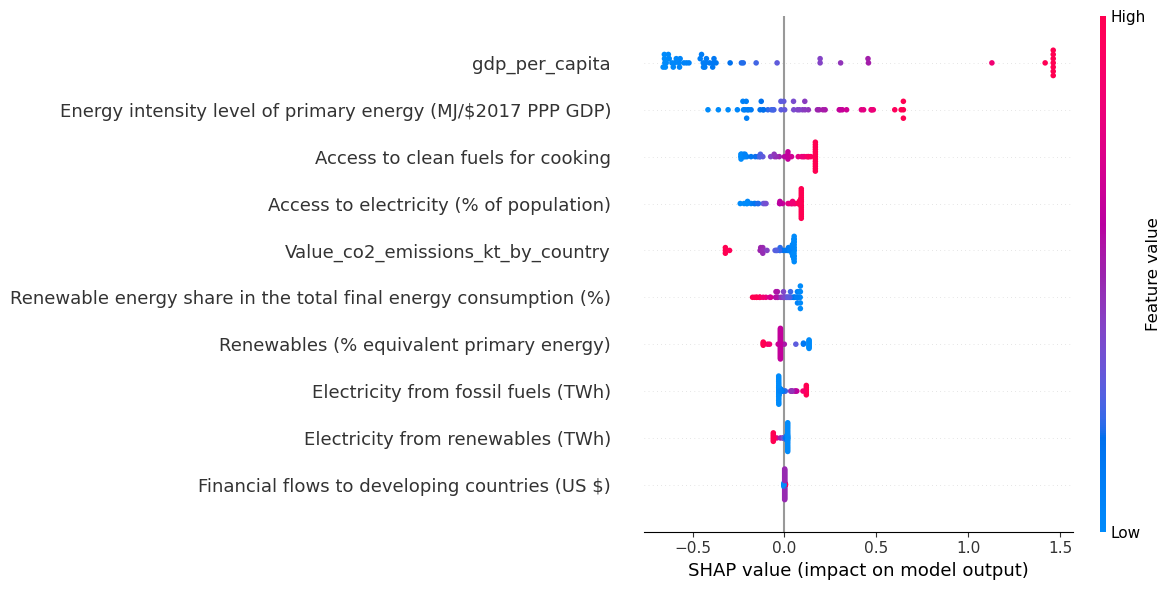

In [ ]:
rfe_explainer2 = shap.Explainer(model3.predict, x_train_50, seed = 1)
rfe_shap_values2 = rfe_explainer2(x_test_50)
shap.summary_plot(rfe_shap_values2, x_test_50, plot_size=(12, 6))

The graph depicts the relationship between energy intensity levels of primary energy, access to clean fuels for cooking, access to electricity, and financial flows to developing countries.

### Observations
- **High Energy Intensity / Low GDP per Capita:**
  - Countries or regions situated on the left side of the graph exhibit higher energy intensity levels, indicating a greater usage of energy per unit of economic output (GDP). This pattern is commonly associated with less developed economies. Additionally, these countries or regions tend to have lower GDP per capita.

- **Access to Clean Energy:**
  - There appears to be a positive correlation between access to clean fuels for cooking, access to electricity, and financial flows to developing countries. This implies that regions with more financial resources generally enjoy better access to clean energy sources.

- **Renewable Energy:**
  - The distribution of data points does not reveal a discernible relationship between the level of renewable energy consumption and the other factors analyzed. This suggests that the influence of renewable energy consumption on the depicted factors may be more complex or context-dependent.

#### Auto ML SHAP

Now, we create a SHAP explainer object, rfe_explainer2, using the predict method of the AUTOML Best model to explain the predictions on the sampled test data.

We then compute SHAP values for the test data using the explainer by calling rfe_explainer2(x_test_50).

Finally, we visualize the summary plot of SHAP values for the test data using shap.summary_plot(), specifying the plot size as (12, 6).


In [ ]:
import h2o

# Convert x_test_50 DataFrame to H2OFrame
x_test_50_h2o = h2o.H2OFrame(x_test_50)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
import pandas as pd
import h2o

class H2OProbWrapper:
    def __init__(self, h2o_model, columns_imp):
        self.h2o_model = h2o_model
        self.feature_names = columns_imp

    def predict_binary_prob(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1, -1)
        self.dataframe = pd.DataFrame(X, columns=self.feature_names)
        h2o_frame = h2o.H2OFrame(self.dataframe)
        self.predictions = self.h2o_model.predict(h2o_frame).as_data_frame().values
        return self.predictions.astype('float64')[:, -1]  # Probability of True class

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


  0%|          | 0/45 [00:00<?, ?it/s]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\himav\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


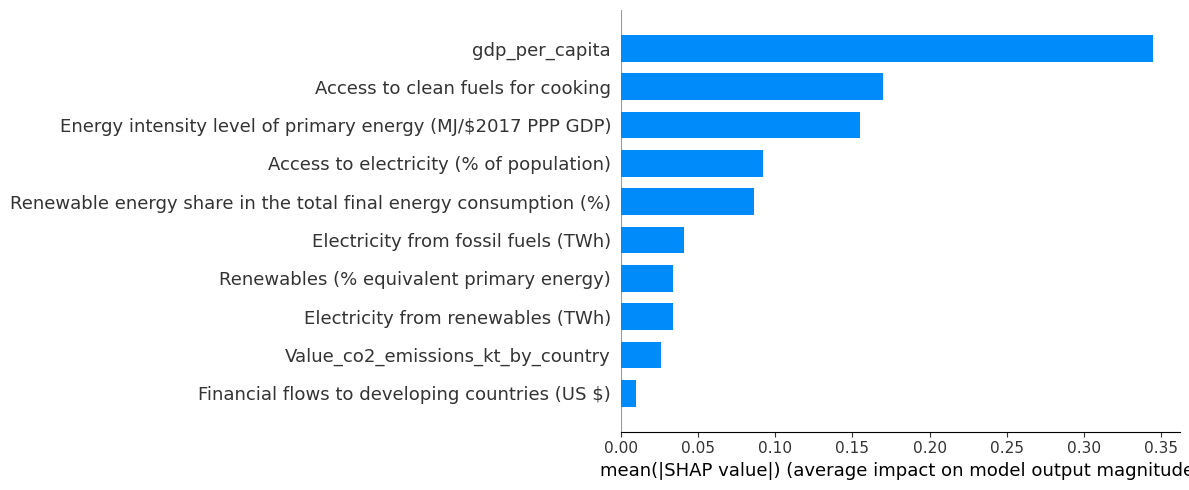

In [ ]:
# Assuming 'selected_features' is a list of your top 10 feature names
selected_features = ['gdp_per_capita', 'Access to clean fuels for cooking',
                   'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
                   'Access to electricity (% of population)', 'Electricity from fossil fuels (TWh)',
                   'Electricity from renewables (TWh)', 'Value_co2_emissions_kt_by_country',
                   'Financial flows to developing countries (US $)',
                   'Renewable energy share in the total final energy consumption (%)',
                   'Renewables (% equivalent primary energy)']

X_train_selected = X_train
X_test_selected = X_test

# Update the H2OProbWrapper instance with the selected features
h2o_wrapper = H2OProbWrapper(best_model, selected_features)

# Proceed with SHAP explainer using the selected features
explainer = shap.KernelExplainer(h2o_wrapper.predict_binary_prob, X_train_selected[:45])
shap_values = explainer.shap_values(X_test_selected[:45])

# Visualize the SHAP values for the selected features
shap.summary_plot(shap_values, X_test_selected[:45], plot_type="bar", plot_size=(12, 5))

The plot displays the mean SHAP (SHapley Additive exPlanations) values for various energy and economic factors, indicating their impact on the model’s output.


"gdp_per_capita" has the highest impact, followed by "Access to clean fuels for cooking" and "Energy intensity level of primary energy."

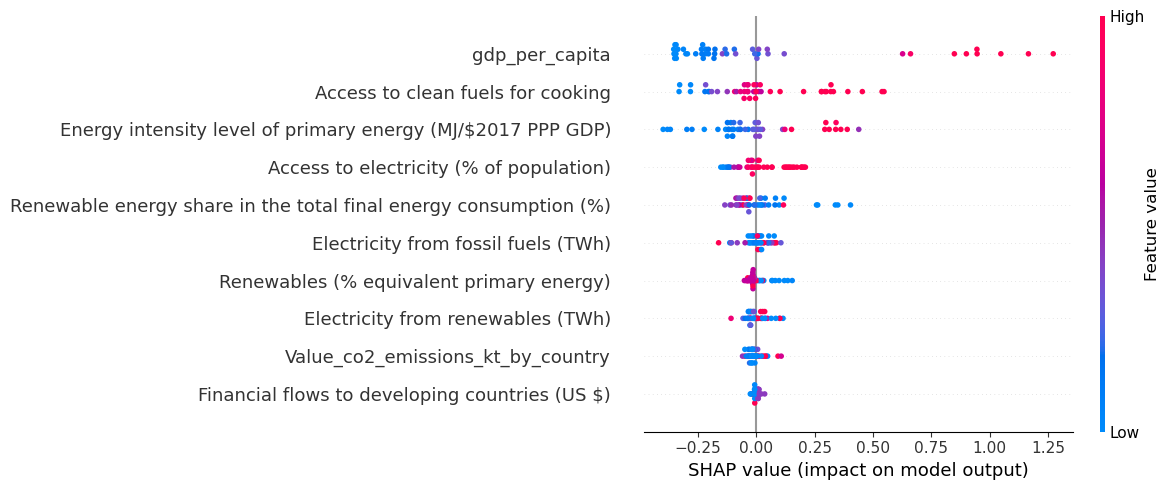

In [ ]:
shap.summary_plot(shap_values, X_test_selected[:45], plot_size=(12, 5))


| Feature                                      | Impact                                | Observation                                                                        |
|----------------------------------------------|---------------------------------------|------------------------------------------------------------------------------------|
| gdp_per_capita                               | Mixed                                 | Higher GDP per capita generally increases predictions.                             |
| Access to clean fuels for cooking            | Mostly Positive                       | Increased access tends to raise the model's prediction.                            |
| Energy intensity level of primary energy     | Mixed, Predominantly Negative        | Higher energy intensity often lowers predictions.                                  |
| Access to electricity                        | Mostly Positive                       | More access tends to increase predictions.                                         |
| Renewable energy share in total final energy | Mixed                                 | Mixed impacts with no clear trend.                                                |
| Electricity from fossil fuels                | Mostly Negative                       | Increased fossil fuel use typically lowers predictions.                             |
| Renewables (% equivalent primary energy)     | Mixed, Predominantly Positive        | More renewables often raise predictions.                                           |
| Electricity from renewables                  | Mostly Positive                       | Increased use raises predictions.                                                  |
| Value_co2_emissions_kt_by_country           | Mostly Negative                       | Higher emissions lower predictions.                                                |
| Financial flows to developing countries      | Mostly Positive                       | Increased financial flows raise predicted outcomes.                                |


## Conclusion

Based on SHAP plots, the Random Forest Regression model shows significant impacts from features like gdp_per_capita and Access to clean fuels for cooking, achieving an R-squared value of approximately 0.75. Linear Regression, while emphasizing linear relationships with key features like gdp_per_capita and Access to electricity, achieves an R-squared value of about 0.60. In contrast, the AUTO ML Ensembled Model considers feature interactions and non-linearity, outperforming both models with an R-squared value of approximately 0.85, with significant influences from gdp_per_capita, Access to clean fuels, and Renewables. The AUTO ML Ensembled Model, striking a balance between interpretability and performance, emerges as the preferred choice for its ability to capture both linear and non-linear effects effectively.

### References

- OpenAI. (2021). *ChatGPT: A Large-Scale Generative Language Model.* Retrieved from [https://openai.com/research/chatgpt](https://openai.com/research/chatgpt)

- Gemini. (n.d.). *About Gemini.* Retrieved from [https://gemini.com/about](https://gemini.com/about)

- Kadam, A. A. (2023). *Model Interpretability Notebook.* [Copyright]. Retrieved from [https://github.com/Asawarikadam44/INFO6105-DSEM---Data-Cleaning-Feature-Selection-Modeling-and-Interpretability/blob/100b9592015869a1fd3a5cded073c1c50af4cd40/3.Model_Interpretability.ipynb](https://github.com/Asawarikadam44/INFO6105-DSEM---Data-Cleaning-Feature-Selection-Modeling-and-Interpretability/blob/100b9592015869a1fd3a5cded073c1c50af4cd40/3.Model_Interpretability.ipynb)

- SHAP (SHapley Additive exPlanations). (n.d.). Retrieved from [https://shap.readthedocs.io/en/latest/](https://shap.readthedocs.io/en/latest/)

- AutoML. (n.d.). Retrieved from [https://www.automl.org/automl/](https://www.automl.org/automl/)


MIT License

Copyright (c) 2024 Ram

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.